In [1]:
import torch
import torch.nn as nn
from dataclasses import dataclass
import torchvision
from torchvision import transforms
from PIL import Image
import os
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter  
from torchvision.utils import save_image

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = 'cpu'
device

'cuda'

In [3]:
@dataclass
class ModelArgs:
    device = 'cpu'
    batch_size = 1
    lr = 0.0002
    img_size = 256
    no_of_channels = 3
    kernel_size = (4,4)
    stride = 2
    dropout = 0.5
    padding = 1
    lr_slope = 0.2
    beta_1 = 0.5
    beta_2 = 0.999
    lambda_gen = 100

In [4]:
ModelArgs.device = device

In [5]:
# #Transforms for images
# transforms = torchvision.transforms.Compose([
#     transforms.Resize(size=(ModelArgs.img_size,ModelArgs.img_size)),
#     transforms.ToTensor(),
#     transforms.Normalize((0.5,), (0.5,))

# ])

In [6]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)  #mean = 0, std = 0.02


In [7]:
import torch
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.main = nn.Sequential(
            nn.Conv2d(ModelArgs.no_of_channels, 64, kernel_size=ModelArgs.kernel_size, stride=ModelArgs.stride, padding=ModelArgs.padding, padding_mode='reflect'),
            nn.LeakyReLU(negative_slope=ModelArgs.lr_slope),

            nn.Conv2d(64, 128, kernel_size=ModelArgs.kernel_size, stride=ModelArgs.stride, padding=ModelArgs.padding, padding_mode='reflect'),
            nn.InstanceNorm2d(128, affine=True),
            nn.LeakyReLU(negative_slope=ModelArgs.lr_slope),

            nn.Conv2d(128, 256, kernel_size=ModelArgs.kernel_size, stride=ModelArgs.stride, padding=ModelArgs.padding, padding_mode='reflect'),
            nn.InstanceNorm2d(256, affine=True),
            nn.LeakyReLU(negative_slope=ModelArgs.lr_slope),

            nn.Conv2d(256, 512, kernel_size=ModelArgs.kernel_size, stride=ModelArgs.stride, padding=ModelArgs.padding, padding_mode='reflect'),
            nn.InstanceNorm2d(512, affine=True),
            nn.LeakyReLU(negative_slope=ModelArgs.lr_slope),

            nn.Conv2d(512, 512, kernel_size=ModelArgs.kernel_size, stride=ModelArgs.stride, padding=ModelArgs.padding, padding_mode='reflect'),
            nn.InstanceNorm2d(512, affine=True),
            nn.LeakyReLU(negative_slope=ModelArgs.lr_slope),

            nn.Conv2d(512, 512, kernel_size=ModelArgs.kernel_size, stride=ModelArgs.stride, padding=ModelArgs.padding, padding_mode='reflect'),
            nn.InstanceNorm2d(512, affine=True),
            nn.LeakyReLU(negative_slope=ModelArgs.lr_slope),

            nn.Conv2d(512, 512, kernel_size=ModelArgs.kernel_size, stride=1, padding=ModelArgs.padding, padding_mode='reflect'),
            nn.InstanceNorm2d(512, affine=True),
            nn.LeakyReLU(negative_slope=ModelArgs.lr_slope),

            nn.Conv2d(512, 512, kernel_size=ModelArgs.kernel_size, stride=1 ,padding=ModelArgs.padding, padding_mode='reflect'),
            nn.InstanceNorm2d(512, affine=True),
            nn.LeakyReLU(negative_slope=ModelArgs.lr_slope)
        )

    def forward(self, x):
        skip_connection = []
        for layer in self.main:
            x = layer(x)
            if isinstance(layer, nn.LeakyReLU):
                skip_connection.append(x)
        return x, skip_connection


In [20]:
random = torch.randn((ModelArgs.batch_size, ModelArgs.no_of_channels, ModelArgs.img_size, ModelArgs.img_size), device=ModelArgs.device)
enc = enc.to(ModelArgs.device)
x, skip_connection = enc(random)

In [18]:
from torchinfo import summary

# images = torch.randn(64, 1, 64, 64)
# labels = torch.randint(0, 10, (64,), dtype=torch.long)
enc = Encoder()
summary(model=enc,
        input_size=(ModelArgs.batch_size, ModelArgs.no_of_channels, ModelArgs.img_size, ModelArgs.img_size),
        # input_data=(images.to(ModelArgs.device), labels.to(ModelArgs.device)),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
Encoder (Encoder)                        [1, 3, 256, 256]     [1, 512, 2, 2]       --                   True
├─Sequential (main)                      --                   --                   --                   True
│    └─Conv2d (0)                        [1, 3, 256, 256]     [1, 64, 128, 128]    3,136                True
│    └─LeakyReLU (1)                     [1, 64, 128, 128]    [1, 64, 128, 128]    --                   --
│    └─Conv2d (2)                        [1, 64, 128, 128]    [1, 128, 64, 64]     131,200              True
│    └─InstanceNorm2d (3)                [1, 128, 64, 64]     [1, 128, 64, 64]     256                  True
│    └─LeakyReLU (4)                     [1, 128, 64, 64]     [1, 128, 64, 64]     --                   --
│    └─Conv2d (5)                        [1, 128, 64, 64]     [1, 256, 32, 32]     524,544              True
│    └─InstanceNor

In [8]:
class Decoder(nn.Module):
    def __init__(self):
        
        super().__init__()
        
        self.main = nn.Sequential(
            
            # nn.Upsample(size=(3,3)),
            nn.ConvTranspose2d(512, 512, kernel_size=ModelArgs.kernel_size, stride=1, padding=ModelArgs.padding),
            nn.InstanceNorm2d(512*2,affine=True),
            nn.Dropout(p=ModelArgs.dropout),
            nn.ReLU(),
            # print("DOnE"),
            
            # nn.Upsample(size=(4,4)),
            nn.ConvTranspose2d(512*2, 512, kernel_size=ModelArgs.kernel_size, stride=1, padding=ModelArgs.padding),
            nn.InstanceNorm2d(512*2,affine=True),
            nn.Dropout(p=ModelArgs.dropout),
            nn.ReLU(),
               
            # nn.Upsample(size=(8,8)),
            nn.ConvTranspose2d(512*2, 512, kernel_size=ModelArgs.kernel_size, stride=ModelArgs.stride, padding=ModelArgs.padding),
            nn.InstanceNorm2d(512*2,affine=True),
            nn.Dropout(p=ModelArgs.dropout),
            nn.ReLU(),
            
            # nn.Upsample(size=(16,16)),
            nn.ConvTranspose2d(512*2, 512, kernel_size=ModelArgs.kernel_size, stride=ModelArgs.stride, padding=ModelArgs.padding),
            nn.InstanceNorm2d(512*2,affine=True),
            # nn.Dropout(p=ModelArgs.dropout),
            nn.ReLU(),
            
            # nn.Upsample(size=(32,32)),
            nn.ConvTranspose2d(512*2, 256, kernel_size=ModelArgs.kernel_size, stride=ModelArgs.stride,padding=ModelArgs.padding),
            nn.InstanceNorm2d(256*2,affine=True),
            nn.ReLU(),
            
            # nn.Upsample(size=(64,64)),
            nn.ConvTranspose2d(256*2, 128, kernel_size=ModelArgs.kernel_size, stride=ModelArgs.stride,padding=ModelArgs.padding),
            nn.InstanceNorm2d(128*2,affine=True),
            nn.ReLU(),

            # nn.Upsample(size=(128,128)),
            nn.ConvTranspose2d(128*2, 64, kernel_size=ModelArgs.kernel_size, stride=ModelArgs.stride,padding=ModelArgs.padding),
            nn.InstanceNorm2d(64*2,affine=True),
            nn.ReLU(),
            
            # nn.Upsample(size=(256,256)),
            # nn.Conv2d(256*2, 128, kernel_size=ModelArgs.kernel_size, padding=ModelArgs.padding),
            # nn.InstanceNorm2d(128,affine=True),
            # nn.ReLU(),
            
            
            nn.ConvTranspose2d(64*2, ModelArgs.no_of_channels, kernel_size=ModelArgs.kernel_size, stride=ModelArgs.stride, padding=ModelArgs.padding),
            nn.Tanh(),
        )
        
    def forward(self, x, skip_connection):
        
        skip_connection = skip_connection[-2::-1]
        count = 0
        for idx, layer in enumerate(self.main):
            
            # print("Original: ", x.shape)
            if (isinstance(layer, nn.Conv2d) or isinstance(layer, nn.ConvTranspose2d)) and count < len(skip_connection):
                
                # print(f"Before applying layer{layer}", x.shape)
                x = layer(x)
                # print(f"After applying layer{layer}:", x.shape)
                # print("Skip connection:",skip_connection[count].shape)
                x = torch.concat([x, skip_connection[count]], dim=1)
                # print("Final: ", x.shape)
                # print(count)
                count += 1
            else:
                # print(f"Before applying layer{layer}", x.shape)
                x = layer(x)
                # print(f"After applying layer{layer}:", x.shape)
        return x


In [24]:
from torchinfo import summary

# images = torch.randn(64, 1, 64, 64)
# labels = torch.ran\dint(0, 10, (64,), dtype=torch.long)
dec = Decoder()
dec = dec.to(ModelArgs.device)
summary(model=dec,
        input_data=(x, skip_connection),
        # input_data=(images.to(ModelArgs.device), labels.to(ModelArgs.device)),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
Decoder (Decoder)                        [1, 512, 2, 2]       [1, 3, 256, 256]     --                   True
├─Sequential (main)                      --                   --                   --                   True
│    └─ConvTranspose2d (0)               [1, 512, 2, 2]       [1, 512, 3, 3]       4,194,816            True
│    └─InstanceNorm2d (1)                [1, 1024, 3, 3]      [1, 1024, 3, 3]      2,048                True
│    └─Dropout (2)                       [1, 1024, 3, 3]      [1, 1024, 3, 3]      --                   --
│    └─ReLU (3)                          [1, 1024, 3, 3]      [1, 1024, 3, 3]      --                   --
│    └─ConvTranspose2d (4)               [1, 1024, 3, 3]      [1, 512, 4, 4]       8,389,120            True
│    └─InstanceNorm2d (5)                [1, 1024, 4, 4]      [1, 1024, 4, 4]      2,048                True
│    └─Dropout (6)

In [9]:
class UNet(nn.Module):
    def __init__(
        self
    ):
        super().__init__()
        
        self.encoder = Encoder()
        self.decoder = Decoder()
        
    def forward(self, x):
        
        x, skip_connection = self.encoder(x)
        x = self.decoder(x, skip_connection)
        return x

In [61]:
#Intializing the Discriminator instance
unet = UNet().to(ModelArgs.device)
#Apply the wieght intilization function layer by layer
unet = unet.apply(weights_init)
#Printing the structure
print(unet)

UNet(
  (encoder): Encoder(
    (main): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2)
      (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (4): LeakyReLU(negative_slope=0.2)
      (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (7): LeakyReLU(negative_slope=0.2)
      (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (9): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (10): LeakyReLU(negative_slope=0.2)
      (11): Conv2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (12): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      

In [64]:

from torchinfo import summary

# images = torch.randn(ModelArgs.batch_size, ModelArgs.no_of_channels, ModelArgs.img_size, ModelArgs.img_size)
# labels = torch.randint(0, 10, (64,), dtype=torch.long)

summary(model=unet,
        input_size=(ModelArgs.batch_size, ModelArgs.no_of_channels, ModelArgs.img_size, ModelArgs.img_size),
        # input_data=(images.to(ModelArgs.device), labels.to(ModelArgs.device)),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])


Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
UNet (UNet)                              [1, 3, 256, 256]     [1, 3, 256, 256]     --                   True
├─Encoder (encoder)                      [1, 3, 256, 256]     [1, 512, 2, 2]       --                   True
│    └─Sequential (main)                 --                   --                   --                   True
│    │    └─Conv2d (0)                   [1, 3, 256, 256]     [1, 64, 128, 128]    3,136                True
│    │    └─LeakyReLU (1)                [1, 64, 128, 128]    [1, 64, 128, 128]    --                   --
│    │    └─Conv2d (2)                   [1, 64, 128, 128]    [1, 128, 64, 64]     131,200              True
│    │    └─InstanceNorm2d (3)           [1, 128, 64, 64]     [1, 128, 64, 64]     256                  True
│    │    └─LeakyReLU (4)                [1, 128, 64, 64]     [1, 128, 64, 64]     --                   --
│    │    └─Conv2d

In [10]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.main = nn.Sequential(
            nn.Conv2d(ModelArgs.no_of_channels*2, 64, kernel_size=ModelArgs.kernel_size, stride=ModelArgs.stride, padding=ModelArgs.padding, padding_mode='reflect'),
            nn.LeakyReLU(negative_slope=ModelArgs.lr_slope),
                
            nn.Conv2d(64, 128, kernel_size=ModelArgs.kernel_size, stride=ModelArgs.stride, padding=ModelArgs.padding, padding_mode='reflect'),
            nn.InstanceNorm2d(128, affine=True),
            nn.LeakyReLU(negative_slope=ModelArgs.lr_slope),
               
            nn.Conv2d(128, 256, kernel_size=ModelArgs.kernel_size, stride=ModelArgs.stride, padding=ModelArgs.padding, padding_mode='reflect'),
            nn.InstanceNorm2d(256, affine=True),
            nn.LeakyReLU(negative_slope=ModelArgs.lr_slope),
              
            nn.Conv2d(256, 512, kernel_size=ModelArgs.kernel_size, stride=1, padding=ModelArgs.padding, padding_mode='reflect'),
            nn.InstanceNorm2d(512, affine=True),
            nn.LeakyReLU(negative_slope=ModelArgs.lr_slope),
            
            nn.Conv2d(512, 1, kernel_size=ModelArgs.kernel_size, stride=1, padding=ModelArgs.padding, padding_mode='reflect'),

            nn.Sigmoid()
        )
        
    def forward(self, x, y):
        res = torch.concat([x, y], dim=1)
        return self.main(res)


In [26]:
#Intializing the Discriminator instance
discriminator = Discriminator().to(ModelArgs.device)
#Apply the wieght intilization function layer by layer
discriminator = discriminator.apply(weights_init)
#Printing the structure
print(discriminator)

Discriminator(
  (main): Sequential(
    (0): Conv2d(6, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
    (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
    (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
    (9): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (10): LeakyReLU(negative_slope=0.2)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
    (12): Sigmoid()
  )
)


In [27]:
from torchinfo import summary

real_A = torch.randn(ModelArgs.batch_size, ModelArgs.no_of_channels, ModelArgs.img_size, ModelArgs.img_size)
real_B = torch.randn(ModelArgs.batch_size, ModelArgs.no_of_channels, ModelArgs.img_size, ModelArgs.img_size)
# labels = torch.randint(0, 10, (64,), dtype=torch.long)

summary(model=discriminator,
        # input_size=(ModelArgs.batch_size, ModelArgs.no_of_channels, ModelArgs.img_size, ModelArgs.img_size),
        input_data=(real_A.to(ModelArgs.device), real_B.to(ModelArgs.device)),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
Discriminator (Discriminator)            [1, 3, 256, 256]     [1, 1, 30, 30]       --                   True
├─Sequential (main)                      [1, 6, 256, 256]     [1, 1, 30, 30]       --                   True
│    └─Conv2d (0)                        [1, 6, 256, 256]     [1, 64, 128, 128]    6,208                True
│    └─LeakyReLU (1)                     [1, 64, 128, 128]    [1, 64, 128, 128]    --                   --
│    └─Conv2d (2)                        [1, 64, 128, 128]    [1, 128, 64, 64]     131,200              True
│    └─InstanceNorm2d (3)                [1, 128, 64, 64]     [1, 128, 64, 64]     256                  True
│    └─LeakyReLU (4)                     [1, 128, 64, 64]     [1, 128, 64, 64]     --                   --
│    └─Conv2d (5)                        [1, 128, 64, 64]     [1, 256, 32, 32]     524,544              True
│    └─InstanceNor

In [11]:
unet = UNet().to(ModelArgs.device).apply(weights_init)
discriminator = Discriminator().to(ModelArgs.device).apply(weights_init)

loss_fn = nn.BCELoss()  #BCELoss function
epochs = 200 #30


optimizerG = torch.optim.Adam(params=unet.parameters(), lr=ModelArgs.lr, betas=(ModelArgs.beta_1, ModelArgs.beta_2)) #For discriminator
optimizerD = torch.optim.Adam(params=discriminator.parameters(), lr=ModelArgs.lr,  betas=(ModelArgs.beta_1, ModelArgs.beta_2)) #For generator



real_label = 1
fake_label = 0


loss_g = []
loss_d = []
img_list = []


In [12]:
#Preparing the dataset

# https://github.com/phillipi/pix2pix/tree/master/datasets

In [13]:
#Config
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2


both_transform = A.Compose(
    [A.Resize(width=ModelArgs.img_size, height=ModelArgs.img_size),], additional_targets={"image0": "image"},
)

transform_only_input = A.Compose(
    [
        # A.HorizontalFlip(p=0.5),
        A.ColorJitter(p=0.2),
        # A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255.0,),
        A.ToFloat(max_value=ModelArgs.img_size),
        ToTensorV2(),
    ]
)

transform_only_mask = A.Compose(
    [
        # A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255.0,),
        A.ToFloat(max_value=ModelArgs.img_size),
        ToTensorV2(),
    ]
)

In [14]:
import numpy as np
class Aerial2MapDataset(Dataset):
    
    def __init__(self, root_dir) -> None:
        super().__init__()
        self.train_path = root_dir
        self.dir = os.listdir(self.train_path)
        
    def __len__(self):
        return len(self.dir)
    
    def __getitem__(self, index):    
        
        current_img = self.dir[index]
        img_path = os.path.join(self.train_path, current_img) 
        img = np.array(Image.open(img_path))
        input = img[:, :600, :]
        mask = img[:, 600:, :]
        augmentataions = both_transform(image = input, image0 = mask)
        input = augmentataions['image']
        mask = augmentataions['image0']
        
        input_transformed = transform_only_input(image = input)['image']
        mask_transformed = transform_only_mask(image = mask)['image']
        
        return input_transformed, mask_transformed

In [15]:
#Creating dataloaders
dir = 'data/maps/train'
train = Aerial2MapDataset(dir)
trainloader = DataLoader(train, batch_size=ModelArgs.batch_size, shuffle=True)
val_dir = 'data/maps/val'
val = Aerial2MapDataset(val_dir)
valloader = DataLoader(val, batch_size=ModelArgs.batch_size, shuffle=False)


In [16]:
from pathlib  import Path
save_images = Path('generated_images/')
# enc = Encoder()

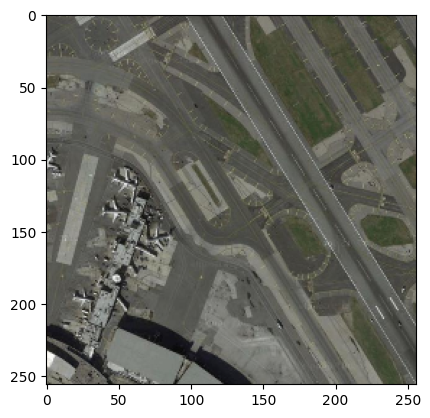

In [18]:
import matplotlib.pyplot as plt
import numpy as np

for X, y in trainloader:
    imageX = X[0]
    # imagey = y[0]

    imageX = imageX.permute(1, 2, 0).numpy()
    # imagey = imagey.permute(1, 2, 0).numpy()
    # Plot the image
    plt.imshow(imageX)
    # plt.imshow(imagey)
    plt.show()
    plt.show()
    break


In [17]:
#Training loop


import random
from tqdm import tqdm


unet.train()
discriminator.train()

iters = 0

writer_fake = SummaryWriter(f"logs/fake")
writer_real = SummaryWriter(f"logs/real")


for epoch in tqdm(range(epochs)):

    for X, y in trainloader:

    
        X = X.to(ModelArgs.device)
        y = y.to(ModelArgs.device)
        
        # print(X.shape)
        # print(y.shape)
        
        #Train the discriminator (with real data)

        ############################
        # (1) Update D network: maximize: log(1 - D(G(z)))
        ###########################
        
        #Enabling the discriminators trainable ability 
        for params in discriminator.parameters():
            params.requires_grad_ = True            
            
        current_batch_size = X.shape[0]  #Getting the current batch size
        
        real_data = torch.ones((current_batch_size,), device=ModelArgs.device, dtype=torch.float32)

        # 1. Forward pass
        y_pred = discriminator(X, y).mean(dim=[2,3]).squeeze(dim=1)
        # print(y_pred)
        # print(y_pred.shape)
        # 2. Calculate  and accumulate loss
        loss_real = loss_fn(y_pred, real_data)

        # 3. Optimizer zero grad
        optimizerD.zero_grad()

       
        # loss_real.backward()


        #Train the discriminator (with fake data)

        # noise = torch.randn((batch_size, latent_vector_size, 1, 1), device=device)
        fake_data = torch.zeros(( current_batch_size,), device=ModelArgs.device, dtype=torch.float32)
        mask_generated_by_generator = unet(X)

        #1. Forward pass
        y_pred = discriminator(X,mask_generated_by_generator.detach()).mean(dim=[2,3]).squeeze(dim=1)


        # 2. Calculate  and accumulate loss
        loss_fake = loss_fn(y_pred, fake_data)


        #Accumulating total discriminator loss
        discriminator_combined_loss = (loss_real + loss_fake) / 2
        loss_d.append(discriminator_combined_loss.item())

         # 4. Loss backward
        discriminator_combined_loss.backward()
        
         # 5. Optimizer step
        optimizerD.step()


        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        
        #Disabling the discriminators trainable ability 
        for params in discriminator.parameters():
            params.requires_grad_ = False
            
        # mask_generated_by_generator = unet(X)
        labels = torch.ones((current_batch_size,), device=ModelArgs.device, dtype=torch.float32)

        #1. Forward pass
        y_pred = discriminator(X, mask_generated_by_generator).mean(dim=[2,3]).squeeze(dim=1)
        # y_pred = torch.argmax(probs, dim=1).type(torch.float32)


        #2. Calculate and accumulate loss
        loss_gen = loss_fn(y_pred,labels) + ModelArgs.lambda_gen * (nn.functional.l1_loss(mask_generated_by_generator, y))


        # 3. Optimizer zero grad
        optimizerG.zero_grad()

        # 4. Loss backward
        loss_gen.backward()

        # 5. Optimizer step
        optimizerG.step()

        loss_g.append(loss_gen.item())


        if iters % 500 == 0:
            print("Iterations: ", iters, "Epoch: ", epoch, "Generator loss: ", loss_gen.item(), "Discriminator loss: ", discriminator_combined_loss.item())

        #save the output
        # with torch.inference_mode():
            
            
            
        if iters % 500 == 0:
            
            print('saving the output')
            torchvision.utils.save_image(y,'{}/real_images_iters_{}.png'.format(save_images, iters),normalize=True)
            fake = unet(X)
            torchvision.utils.save_image(fake,'{}/fake_images_iters_{}.png'.format(save_images, iters),normalize=True)

            img_grid_fake = torchvision.utils.make_grid(fake, normalize=True)
            img_grid_real = torchvision.utils.make_grid(y, normalize=True)
            # img_grid_map = torchvision.utils.make_grid(X, normalize=True)
                
            writer_fake.add_image(
                        "Map2erial Fake Images", img_grid_fake, global_step=iters
                    )
            writer_real.add_image(
                        "Map2Aerial Mask Images", img_grid_real, global_step=iters
                    )
            
            # writer_real.add_image(
            #             "Map2Aerial Aerial Images", img_grid_map, global_step=iters
            #         )
                    

            # Check pointing for every epoch
            # torch.save(generator.state_dict(), 'weights/CelebA/generator_steps_%d.pth' % (iters))
            # torch.save(discriminator.state_dict(), 'weights/CelebA/discriminator_steps_%d.pth' % (iters))


        iters += 1


  0%|          | 0/200 [00:00<?, ?it/s]

Iterations:  0 Epoch:  0 Generator loss:  96.52943420410156 Discriminator loss:  0.7154163718223572
saving the output
Iterations:  500 Epoch:  0 Generator loss:  5.1964030265808105 Discriminator loss:  0.5898436307907104
saving the output
Iterations:  1000 Epoch:  0 Generator loss:  9.825437545776367 Discriminator loss:  0.4932309687137604
saving the output


  0%|          | 1/200 [01:58<6:33:02, 118.50s/it]

Iterations:  1500 Epoch:  1 Generator loss:  5.5915117263793945 Discriminator loss:  0.4908544421195984
saving the output
Iterations:  2000 Epoch:  1 Generator loss:  6.763637542724609 Discriminator loss:  0.3881656527519226
saving the output


  1%|          | 2/200 [04:08<6:52:45, 125.08s/it]

Iterations:  2500 Epoch:  2 Generator loss:  5.823642730712891 Discriminator loss:  0.3276183009147644
saving the output
Iterations:  3000 Epoch:  2 Generator loss:  7.392186164855957 Discriminator loss:  0.4836840033531189
saving the output


  2%|▏         | 3/200 [06:11<6:48:22, 124.38s/it]

Iterations:  3500 Epoch:  3 Generator loss:  5.138985633850098 Discriminator loss:  0.6200096011161804
saving the output
Iterations:  4000 Epoch:  3 Generator loss:  8.76735782623291 Discriminator loss:  0.9331200122833252
saving the output


  2%|▏         | 4/200 [08:13<6:42:17, 123.15s/it]

Iterations:  4500 Epoch:  4 Generator loss:  4.868919849395752 Discriminator loss:  0.4634697437286377
saving the output
Iterations:  5000 Epoch:  4 Generator loss:  6.199641227722168 Discriminator loss:  0.2745419442653656
saving the output


  2%|▎         | 5/200 [10:20<6:45:05, 124.64s/it]

Iterations:  5500 Epoch:  5 Generator loss:  4.462125778198242 Discriminator loss:  0.6583532094955444
saving the output
Iterations:  6000 Epoch:  5 Generator loss:  8.212631225585938 Discriminator loss:  0.2158890962600708
saving the output
Iterations:  6500 Epoch:  5 Generator loss:  9.046602249145508 Discriminator loss:  0.3092106580734253
saving the output


  3%|▎         | 6/200 [12:21<6:39:14, 123.48s/it]

Iterations:  7000 Epoch:  6 Generator loss:  10.627239227294922 Discriminator loss:  0.3242419958114624
saving the output
Iterations:  7500 Epoch:  6 Generator loss:  7.717239856719971 Discriminator loss:  0.25436657667160034
saving the output


  4%|▎         | 7/200 [14:28<6:41:24, 124.79s/it]

Iterations:  8000 Epoch:  7 Generator loss:  4.213342666625977 Discriminator loss:  0.40219175815582275
saving the output
Iterations:  8500 Epoch:  7 Generator loss:  6.518955707550049 Discriminator loss:  0.31306344270706177
saving the output


  4%|▍         | 8/200 [16:31<6:37:05, 124.09s/it]

Iterations:  9000 Epoch:  8 Generator loss:  4.890588283538818 Discriminator loss:  0.5274461507797241
saving the output
Iterations:  9500 Epoch:  8 Generator loss:  6.354137420654297 Discriminator loss:  0.1830262541770935
saving the output


  4%|▍         | 9/200 [18:35<6:35:06, 124.12s/it]

Iterations:  10000 Epoch:  9 Generator loss:  5.105764389038086 Discriminator loss:  0.7715747356414795
saving the output
Iterations:  10500 Epoch:  9 Generator loss:  8.135605812072754 Discriminator loss:  0.23151414096355438
saving the output


  5%|▌         | 10/200 [20:36<6:29:20, 122.95s/it]

Iterations:  11000 Epoch:  10 Generator loss:  6.256604194641113 Discriminator loss:  0.46853673458099365
saving the output
Iterations:  11500 Epoch:  10 Generator loss:  6.475284576416016 Discriminator loss:  0.2859256863594055
saving the output
Iterations:  12000 Epoch:  10 Generator loss:  6.3037543296813965 Discriminator loss:  1.0187225341796875
saving the output


  6%|▌         | 11/200 [22:34<6:22:49, 121.53s/it]

Iterations:  12500 Epoch:  11 Generator loss:  5.065168380737305 Discriminator loss:  0.6986610293388367
saving the output
Iterations:  13000 Epoch:  11 Generator loss:  8.97401237487793 Discriminator loss:  0.0859813317656517
saving the output


  6%|▌         | 12/200 [24:36<6:21:23, 121.72s/it]

Iterations:  13500 Epoch:  12 Generator loss:  5.647447109222412 Discriminator loss:  0.4519992470741272
saving the output
Iterations:  14000 Epoch:  12 Generator loss:  4.912232398986816 Discriminator loss:  0.3526234030723572
saving the output


  6%|▋         | 13/200 [26:44<6:25:09, 123.58s/it]

Iterations:  14500 Epoch:  13 Generator loss:  4.842435359954834 Discriminator loss:  0.42540115118026733
saving the output
Iterations:  15000 Epoch:  13 Generator loss:  8.004968643188477 Discriminator loss:  0.22417686879634857
saving the output


  7%|▋         | 14/200 [28:58<6:32:28, 126.61s/it]

Iterations:  15500 Epoch:  14 Generator loss:  9.250544548034668 Discriminator loss:  0.1491508036851883
saving the output
Iterations:  16000 Epoch:  14 Generator loss:  6.332448482513428 Discriminator loss:  0.6857970356941223
saving the output


  8%|▊         | 15/200 [31:01<6:27:07, 125.55s/it]

Iterations:  16500 Epoch:  15 Generator loss:  5.821287155151367 Discriminator loss:  0.18437883257865906
saving the output
Iterations:  17000 Epoch:  15 Generator loss:  9.045095443725586 Discriminator loss:  0.27576014399528503
saving the output
Iterations:  17500 Epoch:  15 Generator loss:  5.8121137619018555 Discriminator loss:  0.1280568540096283
saving the output


  8%|▊         | 16/200 [33:07<6:25:43, 125.78s/it]

Iterations:  18000 Epoch:  16 Generator loss:  14.178777694702148 Discriminator loss:  0.09005150943994522
saving the output
Iterations:  18500 Epoch:  16 Generator loss:  8.437773704528809 Discriminator loss:  0.1709158569574356
saving the output


  8%|▊         | 17/200 [35:12<6:23:11, 125.64s/it]

Iterations:  19000 Epoch:  17 Generator loss:  5.908158779144287 Discriminator loss:  0.1798419952392578
saving the output
Iterations:  19500 Epoch:  17 Generator loss:  6.44901180267334 Discriminator loss:  0.16460558772087097
saving the output


  9%|▉         | 18/200 [37:19<6:21:43, 125.85s/it]

Iterations:  20000 Epoch:  18 Generator loss:  9.002582550048828 Discriminator loss:  0.13655823469161987
saving the output
Iterations:  20500 Epoch:  18 Generator loss:  8.715266227722168 Discriminator loss:  0.2633724808692932
saving the output


 10%|▉         | 19/200 [39:22<6:17:36, 125.17s/it]

Iterations:  21000 Epoch:  19 Generator loss:  4.668095111846924 Discriminator loss:  0.5935896039009094
saving the output
Iterations:  21500 Epoch:  19 Generator loss:  10.000633239746094 Discriminator loss:  0.0752432569861412
saving the output


 10%|█         | 20/200 [41:24<6:12:34, 124.19s/it]

Iterations:  22000 Epoch:  20 Generator loss:  6.029329299926758 Discriminator loss:  0.405474454164505
saving the output
Iterations:  22500 Epoch:  20 Generator loss:  5.924610614776611 Discriminator loss:  0.3701602816581726
saving the output
Iterations:  23000 Epoch:  20 Generator loss:  7.326996803283691 Discriminator loss:  0.5139775276184082
saving the output


 10%|█         | 21/200 [43:25<6:07:36, 123.22s/it]

Iterations:  23500 Epoch:  21 Generator loss:  6.220357894897461 Discriminator loss:  0.18954460322856903
saving the output
Iterations:  24000 Epoch:  21 Generator loss:  6.953100204467773 Discriminator loss:  0.21483543515205383
saving the output


 11%|█         | 22/200 [45:24<6:01:50, 121.97s/it]

Iterations:  24500 Epoch:  22 Generator loss:  9.565534591674805 Discriminator loss:  0.0787787213921547
saving the output
Iterations:  25000 Epoch:  22 Generator loss:  5.601428031921387 Discriminator loss:  0.41588252782821655
saving the output


 12%|█▏        | 23/200 [47:31<6:03:50, 123.34s/it]

Iterations:  25500 Epoch:  23 Generator loss:  8.20009708404541 Discriminator loss:  0.22331222891807556
saving the output
Iterations:  26000 Epoch:  23 Generator loss:  6.419157981872559 Discriminator loss:  0.41629087924957275
saving the output


 12%|█▏        | 24/200 [49:25<5:54:05, 120.71s/it]

Iterations:  26500 Epoch:  24 Generator loss:  6.3711137771606445 Discriminator loss:  0.2142680585384369
saving the output
Iterations:  27000 Epoch:  24 Generator loss:  7.950704574584961 Discriminator loss:  0.2380608469247818
saving the output


 12%|█▎        | 25/200 [51:23<5:49:52, 119.95s/it]

Iterations:  27500 Epoch:  25 Generator loss:  6.218522071838379 Discriminator loss:  0.08499308675527573
saving the output
Iterations:  28000 Epoch:  25 Generator loss:  7.705378532409668 Discriminator loss:  0.15747323632240295
saving the output


 13%|█▎        | 26/200 [53:27<5:50:47, 120.97s/it]

Iterations:  28500 Epoch:  26 Generator loss:  6.800707817077637 Discriminator loss:  0.25835150480270386
saving the output
Iterations:  29000 Epoch:  26 Generator loss:  7.484038352966309 Discriminator loss:  0.6424232721328735
saving the output
Iterations:  29500 Epoch:  26 Generator loss:  6.384172439575195 Discriminator loss:  0.2604643404483795
saving the output


 14%|█▎        | 27/200 [55:28<5:49:18, 121.14s/it]

Iterations:  30000 Epoch:  27 Generator loss:  7.4493865966796875 Discriminator loss:  0.159807950258255
saving the output
Iterations:  30500 Epoch:  27 Generator loss:  7.685248851776123 Discriminator loss:  0.03465814143419266
saving the output


 14%|█▍        | 28/200 [57:34<5:50:53, 122.40s/it]

Iterations:  31000 Epoch:  28 Generator loss:  11.090718269348145 Discriminator loss:  0.09472218155860901
saving the output
Iterations:  31500 Epoch:  28 Generator loss:  7.028194427490234 Discriminator loss:  0.1746033877134323
saving the output


 14%|█▍        | 29/200 [59:40<5:51:57, 123.50s/it]

Iterations:  32000 Epoch:  29 Generator loss:  6.435983657836914 Discriminator loss:  0.2864917814731598
saving the output
Iterations:  32500 Epoch:  29 Generator loss:  10.829851150512695 Discriminator loss:  0.01968448981642723
saving the output


 15%|█▌        | 30/200 [1:01:45<5:51:22, 124.02s/it]

Iterations:  33000 Epoch:  30 Generator loss:  8.203082084655762 Discriminator loss:  0.3233107030391693
saving the output
Iterations:  33500 Epoch:  30 Generator loss:  6.777706146240234 Discriminator loss:  0.25095486640930176
saving the output


 16%|█▌        | 31/200 [1:03:36<5:38:07, 120.05s/it]

Iterations:  34000 Epoch:  31 Generator loss:  7.329602241516113 Discriminator loss:  0.18878544867038727
saving the output
Iterations:  34500 Epoch:  31 Generator loss:  8.941879272460938 Discriminator loss:  0.10212624073028564
saving the output
Iterations:  35000 Epoch:  31 Generator loss:  4.372428894042969 Discriminator loss:  0.30053919553756714
saving the output


 16%|█▌        | 32/200 [1:05:32<5:32:57, 118.91s/it]

Iterations:  35500 Epoch:  32 Generator loss:  7.291077136993408 Discriminator loss:  0.09280224144458771
saving the output
Iterations:  36000 Epoch:  32 Generator loss:  11.738517761230469 Discriminator loss:  0.11727640777826309
saving the output


 16%|█▋        | 33/200 [1:07:30<5:30:21, 118.69s/it]

Iterations:  36500 Epoch:  33 Generator loss:  7.006303787231445 Discriminator loss:  0.02426006644964218
saving the output
Iterations:  37000 Epoch:  33 Generator loss:  9.54304313659668 Discriminator loss:  0.16323897242546082
saving the output


 17%|█▋        | 34/200 [1:09:23<5:23:11, 116.82s/it]

Iterations:  37500 Epoch:  34 Generator loss:  10.996016502380371 Discriminator loss:  0.07591208815574646
saving the output
Iterations:  38000 Epoch:  34 Generator loss:  3.668553113937378 Discriminator loss:  0.7349716424942017
saving the output


 18%|█▊        | 35/200 [1:11:22<5:23:08, 117.51s/it]

Iterations:  38500 Epoch:  35 Generator loss:  5.6585283279418945 Discriminator loss:  0.2345341145992279
saving the output
Iterations:  39000 Epoch:  35 Generator loss:  6.610742568969727 Discriminator loss:  0.07232576608657837
saving the output


 18%|█▊        | 36/200 [1:13:18<5:20:11, 117.15s/it]

Iterations:  39500 Epoch:  36 Generator loss:  9.63827896118164 Discriminator loss:  0.20171687006950378
saving the output
Iterations:  40000 Epoch:  36 Generator loss:  12.532807350158691 Discriminator loss:  0.10842235386371613
saving the output
Iterations:  40500 Epoch:  36 Generator loss:  9.048198699951172 Discriminator loss:  0.13272611796855927
saving the output


 18%|█▊        | 37/200 [1:15:16<5:19:07, 117.47s/it]

Iterations:  41000 Epoch:  37 Generator loss:  8.761215209960938 Discriminator loss:  0.0627485066652298
saving the output
Iterations:  41500 Epoch:  37 Generator loss:  12.611988067626953 Discriminator loss:  0.051973018795251846
saving the output


 19%|█▉        | 38/200 [1:17:07<5:11:38, 115.42s/it]

Iterations:  42000 Epoch:  38 Generator loss:  10.195879936218262 Discriminator loss:  0.0134430518373847
saving the output
Iterations:  42500 Epoch:  38 Generator loss:  11.093204498291016 Discriminator loss:  0.06218917667865753
saving the output


 20%|█▉        | 39/200 [1:18:59<5:07:05, 114.44s/it]

Iterations:  43000 Epoch:  39 Generator loss:  12.363235473632812 Discriminator loss:  0.04913261532783508
saving the output
Iterations:  43500 Epoch:  39 Generator loss:  8.359941482543945 Discriminator loss:  0.05936884507536888
saving the output


 20%|██        | 40/200 [1:20:49<5:01:56, 113.23s/it]

Iterations:  44000 Epoch:  40 Generator loss:  14.785985946655273 Discriminator loss:  0.01684902422130108
saving the output
Iterations:  44500 Epoch:  40 Generator loss:  17.601606369018555 Discriminator loss:  0.10377857089042664
saving the output


 20%|██        | 41/200 [1:22:43<5:00:11, 113.28s/it]

Iterations:  45000 Epoch:  41 Generator loss:  9.026198387145996 Discriminator loss:  0.14570385217666626
saving the output
Iterations:  45500 Epoch:  41 Generator loss:  11.387351989746094 Discriminator loss:  0.055204614996910095
saving the output
Iterations:  46000 Epoch:  41 Generator loss:  11.092284202575684 Discriminator loss:  0.07577194273471832
saving the output


 21%|██        | 42/200 [1:24:30<4:53:49, 111.58s/it]

Iterations:  46500 Epoch:  42 Generator loss:  7.517099380493164 Discriminator loss:  0.27480849623680115
saving the output
Iterations:  47000 Epoch:  42 Generator loss:  6.483560562133789 Discriminator loss:  0.18992644548416138
saving the output


 22%|██▏       | 43/200 [1:26:19<4:49:50, 110.77s/it]

Iterations:  47500 Epoch:  43 Generator loss:  8.896167755126953 Discriminator loss:  0.13826408982276917
saving the output
Iterations:  48000 Epoch:  43 Generator loss:  12.247031211853027 Discriminator loss:  0.1514529585838318
saving the output


 22%|██▏       | 44/200 [1:28:14<4:51:25, 112.09s/it]

Iterations:  48500 Epoch:  44 Generator loss:  9.474604606628418 Discriminator loss:  0.10617799311876297
saving the output
Iterations:  49000 Epoch:  44 Generator loss:  10.619305610656738 Discriminator loss:  0.11779393255710602
saving the output


 22%|██▎       | 45/200 [1:30:04<4:47:12, 111.18s/it]

Iterations:  49500 Epoch:  45 Generator loss:  10.780731201171875 Discriminator loss:  0.10792886465787888
saving the output
Iterations:  50000 Epoch:  45 Generator loss:  12.735764503479004 Discriminator loss:  0.039687734097242355
saving the output


 23%|██▎       | 46/200 [1:31:51<4:42:31, 110.08s/it]

Iterations:  50500 Epoch:  46 Generator loss:  15.2526273727417 Discriminator loss:  0.07221045345067978
saving the output
Iterations:  51000 Epoch:  46 Generator loss:  11.641104698181152 Discriminator loss:  0.054919060319662094
saving the output
Iterations:  51500 Epoch:  46 Generator loss:  11.729202270507812 Discriminator loss:  0.16890814900398254
saving the output


 24%|██▎       | 47/200 [1:33:42<4:41:11, 110.27s/it]

Iterations:  52000 Epoch:  47 Generator loss:  11.001822471618652 Discriminator loss:  0.249247208237648
saving the output
Iterations:  52500 Epoch:  47 Generator loss:  8.771393775939941 Discriminator loss:  0.10041536390781403
saving the output


 24%|██▍       | 48/200 [1:35:33<4:40:15, 110.63s/it]

Iterations:  53000 Epoch:  48 Generator loss:  16.251487731933594 Discriminator loss:  0.05632510036230087
saving the output
Iterations:  53500 Epoch:  48 Generator loss:  7.526795387268066 Discriminator loss:  0.04295628145337105
saving the output


 24%|██▍       | 49/200 [1:37:27<4:40:59, 111.65s/it]

Iterations:  54000 Epoch:  49 Generator loss:  10.331695556640625 Discriminator loss:  0.08559711277484894
saving the output
Iterations:  54500 Epoch:  49 Generator loss:  13.497664451599121 Discriminator loss:  0.06616583466529846
saving the output


 25%|██▌       | 50/200 [1:39:17<4:37:34, 111.03s/it]

Iterations:  55000 Epoch:  50 Generator loss:  7.773091793060303 Discriminator loss:  0.05381856858730316
saving the output
Iterations:  55500 Epoch:  50 Generator loss:  5.051961421966553 Discriminator loss:  0.26146525144577026
saving the output


 26%|██▌       | 51/200 [1:41:05<4:33:56, 110.31s/it]

Iterations:  56000 Epoch:  51 Generator loss:  8.29937744140625 Discriminator loss:  0.11042453348636627
saving the output
Iterations:  56500 Epoch:  51 Generator loss:  11.667223930358887 Discriminator loss:  0.08305740356445312
saving the output


 26%|██▌       | 52/200 [1:42:55<4:31:15, 109.97s/it]

Iterations:  57000 Epoch:  52 Generator loss:  7.05422306060791 Discriminator loss:  0.33783799409866333
saving the output
Iterations:  57500 Epoch:  52 Generator loss:  10.23061752319336 Discriminator loss:  0.11773832142353058
saving the output
Iterations:  58000 Epoch:  52 Generator loss:  8.464187622070312 Discriminator loss:  0.0831063762307167
saving the output


 26%|██▋       | 53/200 [1:44:45<4:29:57, 110.19s/it]

Iterations:  58500 Epoch:  53 Generator loss:  9.233905792236328 Discriminator loss:  0.06450675427913666
saving the output
Iterations:  59000 Epoch:  53 Generator loss:  7.902225494384766 Discriminator loss:  0.03972376137971878
saving the output


 27%|██▋       | 54/200 [1:46:34<4:26:46, 109.64s/it]

Iterations:  59500 Epoch:  54 Generator loss:  10.289576530456543 Discriminator loss:  0.014810077846050262
saving the output
Iterations:  60000 Epoch:  54 Generator loss:  10.164451599121094 Discriminator loss:  0.10268273949623108
saving the output


 28%|██▊       | 55/200 [1:48:26<4:27:08, 110.54s/it]

Iterations:  60500 Epoch:  55 Generator loss:  8.780810356140137 Discriminator loss:  0.05238844081759453
saving the output
Iterations:  61000 Epoch:  55 Generator loss:  10.939977645874023 Discriminator loss:  0.07689663022756577
saving the output


 28%|██▊       | 56/200 [1:50:17<4:25:34, 110.66s/it]

Iterations:  61500 Epoch:  56 Generator loss:  12.948785781860352 Discriminator loss:  0.06734824925661087
saving the output
Iterations:  62000 Epoch:  56 Generator loss:  10.988003730773926 Discriminator loss:  0.0999610498547554
saving the output


 28%|██▊       | 57/200 [1:52:11<4:25:49, 111.54s/it]

Iterations:  62500 Epoch:  57 Generator loss:  11.092521667480469 Discriminator loss:  0.05719750002026558
saving the output
Iterations:  63000 Epoch:  57 Generator loss:  17.199119567871094 Discriminator loss:  0.08604950457811356
saving the output
Iterations:  63500 Epoch:  57 Generator loss:  13.053705215454102 Discriminator loss:  0.014796562492847443
saving the output


 29%|██▉       | 58/200 [1:54:02<4:23:21, 111.28s/it]

Iterations:  64000 Epoch:  58 Generator loss:  14.450337409973145 Discriminator loss:  0.04768691211938858
saving the output
Iterations:  64500 Epoch:  58 Generator loss:  13.342700958251953 Discriminator loss:  0.056431885808706284
saving the output


 30%|██▉       | 59/200 [1:55:53<4:21:49, 111.41s/it]

Iterations:  65000 Epoch:  59 Generator loss:  21.146160125732422 Discriminator loss:  0.04626089707016945
saving the output
Iterations:  65500 Epoch:  59 Generator loss:  12.909688949584961 Discriminator loss:  0.04178549349308014
saving the output


 30%|███       | 60/200 [1:57:46<4:20:34, 111.68s/it]

Iterations:  66000 Epoch:  60 Generator loss:  8.327857971191406 Discriminator loss:  0.07793249189853668
saving the output
Iterations:  66500 Epoch:  60 Generator loss:  12.757440567016602 Discriminator loss:  0.07361175119876862
saving the output


 30%|███       | 61/200 [1:59:37<4:18:34, 111.61s/it]

Iterations:  67000 Epoch:  61 Generator loss:  11.414057731628418 Discriminator loss:  0.040135327726602554
saving the output
Iterations:  67500 Epoch:  61 Generator loss:  20.01642608642578 Discriminator loss:  0.047206588089466095
saving the output


 31%|███       | 62/200 [2:01:27<4:15:47, 111.21s/it]

Iterations:  68000 Epoch:  62 Generator loss:  8.005760192871094 Discriminator loss:  0.045052044093608856
saving the output
Iterations:  68500 Epoch:  62 Generator loss:  17.86408805847168 Discriminator loss:  7.976635970408097e-05
saving the output
Iterations:  69000 Epoch:  62 Generator loss:  14.221963882446289 Discriminator loss:  0.20061607658863068
saving the output


 32%|███▏      | 63/200 [2:03:19<4:14:03, 111.27s/it]

Iterations:  69500 Epoch:  63 Generator loss:  16.192644119262695 Discriminator loss:  0.005122072994709015
saving the output
Iterations:  70000 Epoch:  63 Generator loss:  7.691953659057617 Discriminator loss:  0.03860624134540558
saving the output


 32%|███▏      | 64/200 [2:05:12<4:13:36, 111.88s/it]

Iterations:  70500 Epoch:  64 Generator loss:  13.287263870239258 Discriminator loss:  0.006950222887098789
saving the output
Iterations:  71000 Epoch:  64 Generator loss:  12.076319694519043 Discriminator loss:  0.032612144947052
saving the output


 32%|███▎      | 65/200 [2:07:04<4:11:55, 111.96s/it]

Iterations:  71500 Epoch:  65 Generator loss:  10.652965545654297 Discriminator loss:  0.08845964074134827
saving the output
Iterations:  72000 Epoch:  65 Generator loss:  11.546786308288574 Discriminator loss:  0.007126286160200834
saving the output


 33%|███▎      | 66/200 [2:08:53<4:08:01, 111.06s/it]

Iterations:  72500 Epoch:  66 Generator loss:  7.885106563568115 Discriminator loss:  0.015790004283189774
saving the output
Iterations:  73000 Epoch:  66 Generator loss:  9.151208877563477 Discriminator loss:  0.00955215934664011
saving the output


 34%|███▎      | 67/200 [2:10:48<4:08:24, 112.07s/it]

Iterations:  73500 Epoch:  67 Generator loss:  12.108640670776367 Discriminator loss:  0.017694946378469467
saving the output
Iterations:  74000 Epoch:  67 Generator loss:  9.989222526550293 Discriminator loss:  0.10868245363235474
saving the output
Iterations:  74500 Epoch:  67 Generator loss:  15.871540069580078 Discriminator loss:  0.08975711464881897
saving the output


 34%|███▍      | 68/200 [2:12:41<4:07:22, 112.44s/it]

Iterations:  75000 Epoch:  68 Generator loss:  9.244866371154785 Discriminator loss:  0.010465987958014011
saving the output
Iterations:  75500 Epoch:  68 Generator loss:  13.003091812133789 Discriminator loss:  0.008303509093821049
saving the output


 34%|███▍      | 69/200 [2:14:29<4:02:48, 111.21s/it]

Iterations:  76000 Epoch:  69 Generator loss:  15.520247459411621 Discriminator loss:  0.026452720165252686
saving the output
Iterations:  76500 Epoch:  69 Generator loss:  18.52871322631836 Discriminator loss:  0.01131877675652504
saving the output


 35%|███▌      | 70/200 [2:16:23<4:02:44, 112.04s/it]

Iterations:  77000 Epoch:  70 Generator loss:  9.362457275390625 Discriminator loss:  0.04284803569316864
saving the output
Iterations:  77500 Epoch:  70 Generator loss:  13.722481727600098 Discriminator loss:  0.012204686179757118
saving the output


 36%|███▌      | 71/200 [2:18:15<4:00:53, 112.04s/it]

Iterations:  78000 Epoch:  71 Generator loss:  14.172872543334961 Discriminator loss:  0.0003810013586189598
saving the output
Iterations:  78500 Epoch:  71 Generator loss:  7.724610805511475 Discriminator loss:  0.06218869239091873
saving the output


 36%|███▌      | 72/200 [2:20:07<3:58:53, 111.98s/it]

Iterations:  79000 Epoch:  72 Generator loss:  7.021128177642822 Discriminator loss:  0.3130095601081848
saving the output
Iterations:  79500 Epoch:  72 Generator loss:  4.733254432678223 Discriminator loss:  0.367433100938797
saving the output
Iterations:  80000 Epoch:  72 Generator loss:  9.332012176513672 Discriminator loss:  0.05411373823881149
saving the output


 36%|███▋      | 73/200 [2:21:59<3:56:43, 111.84s/it]

Iterations:  80500 Epoch:  73 Generator loss:  14.297755241394043 Discriminator loss:  0.1132594645023346
saving the output
Iterations:  81000 Epoch:  73 Generator loss:  12.330013275146484 Discriminator loss:  0.0027078643906861544
saving the output


 37%|███▋      | 74/200 [2:23:49<3:54:14, 111.55s/it]

Iterations:  81500 Epoch:  74 Generator loss:  8.628105163574219 Discriminator loss:  0.0393594428896904
saving the output
Iterations:  82000 Epoch:  74 Generator loss:  7.815544128417969 Discriminator loss:  0.09941402077674866
saving the output


 38%|███▊      | 75/200 [2:25:42<3:53:03, 111.87s/it]

Iterations:  82500 Epoch:  75 Generator loss:  10.21881103515625 Discriminator loss:  0.06717747449874878
saving the output
Iterations:  83000 Epoch:  75 Generator loss:  19.69599151611328 Discriminator loss:  0.005724780261516571
saving the output


 38%|███▊      | 76/200 [2:27:36<3:52:18, 112.41s/it]

Iterations:  83500 Epoch:  76 Generator loss:  8.756407737731934 Discriminator loss:  0.022394055500626564
saving the output
Iterations:  84000 Epoch:  76 Generator loss:  10.619470596313477 Discriminator loss:  0.1392745077610016
saving the output


 38%|███▊      | 77/200 [2:29:27<3:49:46, 112.08s/it]

Iterations:  84500 Epoch:  77 Generator loss:  10.077535629272461 Discriminator loss:  0.0800018459558487
saving the output
Iterations:  85000 Epoch:  77 Generator loss:  14.329817771911621 Discriminator loss:  0.000907012028619647
saving the output


 39%|███▉      | 78/200 [2:31:19<3:47:40, 111.97s/it]

Iterations:  85500 Epoch:  78 Generator loss:  15.202131271362305 Discriminator loss:  0.012058883905410767
saving the output
Iterations:  86000 Epoch:  78 Generator loss:  11.699238777160645 Discriminator loss:  0.06863614916801453
saving the output
Iterations:  86500 Epoch:  78 Generator loss:  18.238649368286133 Discriminator loss:  0.07771476358175278
saving the output


 40%|███▉      | 79/200 [2:33:12<3:46:22, 112.25s/it]

Iterations:  87000 Epoch:  79 Generator loss:  16.664901733398438 Discriminator loss:  0.002584020607173443
saving the output
Iterations:  87500 Epoch:  79 Generator loss:  6.736976146697998 Discriminator loss:  0.2322540581226349
saving the output


 40%|████      | 80/200 [2:35:05<3:45:04, 112.54s/it]

Iterations:  88000 Epoch:  80 Generator loss:  21.331331253051758 Discriminator loss:  0.017971735447645187
saving the output
Iterations:  88500 Epoch:  80 Generator loss:  16.998912811279297 Discriminator loss:  9.0944224211853e-05
saving the output


 40%|████      | 81/200 [2:36:55<3:41:53, 111.88s/it]

Iterations:  89000 Epoch:  81 Generator loss:  11.673049926757812 Discriminator loss:  0.004631097428500652
saving the output
Iterations:  89500 Epoch:  81 Generator loss:  22.53615379333496 Discriminator loss:  0.0016226298175752163
saving the output


 41%|████      | 82/200 [2:38:47<3:39:44, 111.73s/it]

Iterations:  90000 Epoch:  82 Generator loss:  13.992962837219238 Discriminator loss:  0.05569108948111534
saving the output
Iterations:  90500 Epoch:  82 Generator loss:  15.400386810302734 Discriminator loss:  0.00010068935807794333
saving the output


 42%|████▏     | 83/200 [2:40:42<3:40:16, 112.96s/it]

Iterations:  91000 Epoch:  83 Generator loss:  19.030624389648438 Discriminator loss:  0.09177438914775848
saving the output
Iterations:  91500 Epoch:  83 Generator loss:  15.779581069946289 Discriminator loss:  0.06086873635649681
saving the output
Iterations:  92000 Epoch:  83 Generator loss:  16.953676223754883 Discriminator loss:  0.00034276294172741473
saving the output


 42%|████▏     | 84/200 [2:42:34<3:37:45, 112.64s/it]

Iterations:  92500 Epoch:  84 Generator loss:  12.776369094848633 Discriminator loss:  0.04574320837855339
saving the output
Iterations:  93000 Epoch:  84 Generator loss:  11.108346939086914 Discriminator loss:  0.0030588428489863873
saving the output


 42%|████▎     | 85/200 [2:44:27<3:35:46, 112.58s/it]

Iterations:  93500 Epoch:  85 Generator loss:  8.672735214233398 Discriminator loss:  0.004313094541430473
saving the output
Iterations:  94000 Epoch:  85 Generator loss:  6.336292743682861 Discriminator loss:  0.12413947284221649
saving the output


 43%|████▎     | 86/200 [2:46:18<3:33:19, 112.28s/it]

Iterations:  94500 Epoch:  86 Generator loss:  11.156513214111328 Discriminator loss:  0.033584896475076675
saving the output
Iterations:  95000 Epoch:  86 Generator loss:  14.086971282958984 Discriminator loss:  0.004137423820793629
saving the output


 44%|████▎     | 87/200 [2:48:14<3:33:26, 113.33s/it]

Iterations:  95500 Epoch:  87 Generator loss:  12.000535011291504 Discriminator loss:  0.06504032015800476
saving the output
Iterations:  96000 Epoch:  87 Generator loss:  7.426759719848633 Discriminator loss:  0.05597171559929848
saving the output


 44%|████▍     | 88/200 [2:50:06<3:30:44, 112.90s/it]

Iterations:  96500 Epoch:  88 Generator loss:  13.190011024475098 Discriminator loss:  0.15424871444702148
saving the output
Iterations:  97000 Epoch:  88 Generator loss:  16.540319442749023 Discriminator loss:  0.03270166367292404
saving the output
Iterations:  97500 Epoch:  88 Generator loss:  8.056678771972656 Discriminator loss:  0.09153095632791519
saving the output


 44%|████▍     | 89/200 [2:51:59<3:28:48, 112.87s/it]

Iterations:  98000 Epoch:  89 Generator loss:  12.667370796203613 Discriminator loss:  0.005161232780665159
saving the output
Iterations:  98500 Epoch:  89 Generator loss:  9.060356140136719 Discriminator loss:  0.03899148106575012
saving the output


 45%|████▌     | 90/200 [2:53:50<3:25:46, 112.25s/it]

Iterations:  99000 Epoch:  90 Generator loss:  8.436429023742676 Discriminator loss:  0.03271264582872391
saving the output
Iterations:  99500 Epoch:  90 Generator loss:  17.471363067626953 Discriminator loss:  0.05048229545354843
saving the output


 46%|████▌     | 91/200 [2:55:44<3:25:06, 112.90s/it]

Iterations:  100000 Epoch:  91 Generator loss:  11.288909912109375 Discriminator loss:  0.05044480413198471
saving the output
Iterations:  100500 Epoch:  91 Generator loss:  20.486186981201172 Discriminator loss:  0.023038560524582863
saving the output


 46%|████▌     | 92/200 [2:57:35<3:22:12, 112.34s/it]

Iterations:  101000 Epoch:  92 Generator loss:  14.98491382598877 Discriminator loss:  0.020074961706995964
saving the output
Iterations:  101500 Epoch:  92 Generator loss:  19.439388275146484 Discriminator loss:  1.0391289833933115e-05
saving the output


 46%|████▋     | 93/200 [2:59:27<3:20:11, 112.26s/it]

Iterations:  102000 Epoch:  93 Generator loss:  21.885541915893555 Discriminator loss:  2.595731075416552e-06
saving the output
Iterations:  102500 Epoch:  93 Generator loss:  13.629342079162598 Discriminator loss:  0.0005993976374156773
saving the output
Iterations:  103000 Epoch:  93 Generator loss:  16.292278289794922 Discriminator loss:  0.1342400461435318
saving the output


 47%|████▋     | 94/200 [3:01:21<3:18:56, 112.61s/it]

Iterations:  103500 Epoch:  94 Generator loss:  12.015378952026367 Discriminator loss:  0.06359442323446274
saving the output
Iterations:  104000 Epoch:  94 Generator loss:  21.233469009399414 Discriminator loss:  0.0021381075493991375
saving the output


 48%|████▊     | 95/200 [3:03:14<3:17:27, 112.83s/it]

Iterations:  104500 Epoch:  95 Generator loss:  13.069421768188477 Discriminator loss:  0.027973905205726624
saving the output
Iterations:  105000 Epoch:  95 Generator loss:  13.218786239624023 Discriminator loss:  0.04884842410683632
saving the output


 48%|████▊     | 96/200 [3:05:08<3:16:25, 113.32s/it]

Iterations:  105500 Epoch:  96 Generator loss:  13.295388221740723 Discriminator loss:  0.0427306704223156
saving the output
Iterations:  106000 Epoch:  96 Generator loss:  20.852344512939453 Discriminator loss:  0.00012654245074372739
saving the output


 48%|████▊     | 97/200 [3:07:00<3:13:43, 112.85s/it]

Iterations:  106500 Epoch:  97 Generator loss:  13.579657554626465 Discriminator loss:  0.05760703235864639
saving the output
Iterations:  107000 Epoch:  97 Generator loss:  12.454902648925781 Discriminator loss:  0.0011569123016670346
saving the output


 49%|████▉     | 98/200 [3:08:51<3:10:57, 112.33s/it]

Iterations:  107500 Epoch:  98 Generator loss:  21.24171257019043 Discriminator loss:  0.024616463109850883
saving the output
Iterations:  108000 Epoch:  98 Generator loss:  18.171733856201172 Discriminator loss:  0.00012818390678148717
saving the output
Iterations:  108500 Epoch:  98 Generator loss:  13.141067504882812 Discriminator loss:  0.005082560237497091
saving the output


 50%|████▉     | 99/200 [3:10:45<3:09:53, 112.81s/it]

Iterations:  109000 Epoch:  99 Generator loss:  11.913345336914062 Discriminator loss:  0.029308654367923737
saving the output
Iterations:  109500 Epoch:  99 Generator loss:  24.949176788330078 Discriminator loss:  1.7918664525495842e-05
saving the output


 50%|█████     | 100/200 [3:12:39<3:08:45, 113.25s/it]

Iterations:  110000 Epoch:  100 Generator loss:  14.715816497802734 Discriminator loss:  3.350681799929589e-05
saving the output
Iterations:  110500 Epoch:  100 Generator loss:  18.181777954101562 Discriminator loss:  0.05187635496258736
saving the output


 50%|█████     | 101/200 [3:14:32<3:06:22, 112.96s/it]

Iterations:  111000 Epoch:  101 Generator loss:  12.699201583862305 Discriminator loss:  0.0009862171718850732
saving the output
Iterations:  111500 Epoch:  101 Generator loss:  13.736482620239258 Discriminator loss:  0.00019029599206987768
saving the output


 51%|█████     | 102/200 [3:16:24<3:04:08, 112.74s/it]

Iterations:  112000 Epoch:  102 Generator loss:  13.17287826538086 Discriminator loss:  0.05302954465150833
saving the output
Iterations:  112500 Epoch:  102 Generator loss:  15.682768821716309 Discriminator loss:  0.0030543063767254353
saving the output


 52%|█████▏    | 103/200 [3:18:15<3:01:25, 112.22s/it]

Iterations:  113000 Epoch:  103 Generator loss:  10.81483268737793 Discriminator loss:  0.004238939844071865
saving the output
Iterations:  113500 Epoch:  103 Generator loss:  11.86678695678711 Discriminator loss:  0.00301663251593709
saving the output


 52%|█████▏    | 104/200 [3:20:10<3:00:53, 113.06s/it]

Iterations:  114000 Epoch:  104 Generator loss:  9.977455139160156 Discriminator loss:  0.0044743274338543415
saving the output
Iterations:  114500 Epoch:  104 Generator loss:  19.219282150268555 Discriminator loss:  0.03666100651025772
saving the output
Iterations:  115000 Epoch:  104 Generator loss:  9.914875030517578 Discriminator loss:  0.005856009665876627
saving the output


 52%|█████▎    | 105/200 [3:22:02<2:58:21, 112.64s/it]

Iterations:  115500 Epoch:  105 Generator loss:  11.272916793823242 Discriminator loss:  0.01450321264564991
saving the output
Iterations:  116000 Epoch:  105 Generator loss:  13.540836334228516 Discriminator loss:  0.004006463102996349
saving the output


 53%|█████▎    | 106/200 [3:23:54<2:56:21, 112.57s/it]

Iterations:  116500 Epoch:  106 Generator loss:  12.26506233215332 Discriminator loss:  0.0027390511240810156
saving the output
Iterations:  117000 Epoch:  106 Generator loss:  11.655424118041992 Discriminator loss:  0.055983059108257294
saving the output


 54%|█████▎    | 107/200 [3:25:46<2:54:01, 112.28s/it]

Iterations:  117500 Epoch:  107 Generator loss:  11.491289138793945 Discriminator loss:  0.015845904126763344
saving the output
Iterations:  118000 Epoch:  107 Generator loss:  8.751635551452637 Discriminator loss:  0.020650377497076988
saving the output


 54%|█████▍    | 108/200 [3:27:40<2:52:53, 112.76s/it]

Iterations:  118500 Epoch:  108 Generator loss:  20.227489471435547 Discriminator loss:  1.2740612191919354e-06
saving the output
Iterations:  119000 Epoch:  108 Generator loss:  5.530441761016846 Discriminator loss:  0.332736998796463
saving the output


 55%|█████▍    | 109/200 [3:29:35<2:52:28, 113.72s/it]

Iterations:  119500 Epoch:  109 Generator loss:  9.827472686767578 Discriminator loss:  0.0085767125710845
saving the output
Iterations:  120000 Epoch:  109 Generator loss:  14.494867324829102 Discriminator loss:  0.013324708677828312
saving the output
Iterations:  120500 Epoch:  109 Generator loss:  8.6443510055542 Discriminator loss:  0.1030707135796547
saving the output


 55%|█████▌    | 110/200 [3:31:28<2:50:10, 113.45s/it]

Iterations:  121000 Epoch:  110 Generator loss:  7.413019180297852 Discriminator loss:  0.09659469127655029
saving the output
Iterations:  121500 Epoch:  110 Generator loss:  12.133306503295898 Discriminator loss:  0.0012898438144475222
saving the output


 56%|█████▌    | 111/200 [3:33:20<2:47:29, 112.91s/it]

Iterations:  122000 Epoch:  111 Generator loss:  9.392167091369629 Discriminator loss:  0.06654377281665802
saving the output
Iterations:  122500 Epoch:  111 Generator loss:  13.133996963500977 Discriminator loss:  0.0009975261054933071
saving the output


 56%|█████▌    | 112/200 [3:35:17<2:47:33, 114.25s/it]

Iterations:  123000 Epoch:  112 Generator loss:  11.576966285705566 Discriminator loss:  0.001112628960981965
saving the output
Iterations:  123500 Epoch:  112 Generator loss:  9.807096481323242 Discriminator loss:  0.0505831241607666
saving the output


 56%|█████▋    | 113/200 [3:37:12<2:45:39, 114.25s/it]

Iterations:  124000 Epoch:  113 Generator loss:  9.60611629486084 Discriminator loss:  0.050097353756427765
saving the output
Iterations:  124500 Epoch:  113 Generator loss:  13.609992980957031 Discriminator loss:  0.12007023394107819
saving the output


 57%|█████▋    | 114/200 [3:39:08<2:44:39, 114.88s/it]

Iterations:  125000 Epoch:  114 Generator loss:  20.470218658447266 Discriminator loss:  9.94869478745386e-05
saving the output
Iterations:  125500 Epoch:  114 Generator loss:  9.148453712463379 Discriminator loss:  0.059153757989406586
saving the output
Iterations:  126000 Epoch:  114 Generator loss:  11.226423263549805 Discriminator loss:  0.05408522114157677
saving the output


 57%|█████▊    | 115/200 [3:41:00<2:41:39, 114.11s/it]

Iterations:  126500 Epoch:  115 Generator loss:  11.513608932495117 Discriminator loss:  0.015370935201644897
saving the output
Iterations:  127000 Epoch:  115 Generator loss:  8.497103691101074 Discriminator loss:  0.013740593567490578
saving the output


 58%|█████▊    | 116/200 [3:42:54<2:39:39, 114.04s/it]

Iterations:  127500 Epoch:  116 Generator loss:  10.528066635131836 Discriminator loss:  0.03706130012869835
saving the output
Iterations:  128000 Epoch:  116 Generator loss:  15.680562973022461 Discriminator loss:  7.857805758249015e-05
saving the output


 58%|█████▊    | 117/200 [3:44:47<2:37:08, 113.59s/it]

Iterations:  128500 Epoch:  117 Generator loss:  10.575525283813477 Discriminator loss:  0.10255727171897888
saving the output
Iterations:  129000 Epoch:  117 Generator loss:  7.560131072998047 Discriminator loss:  0.03215000778436661
saving the output


 59%|█████▉    | 118/200 [3:46:38<2:34:18, 112.90s/it]

Iterations:  129500 Epoch:  118 Generator loss:  12.744504928588867 Discriminator loss:  0.0009981143521144986
saving the output
Iterations:  130000 Epoch:  118 Generator loss:  7.981248378753662 Discriminator loss:  0.12783430516719818
saving the output


 60%|█████▉    | 119/200 [3:48:30<2:31:53, 112.51s/it]

Iterations:  130500 Epoch:  119 Generator loss:  10.757061004638672 Discriminator loss:  0.0024880815763026476
saving the output
Iterations:  131000 Epoch:  119 Generator loss:  7.311792373657227 Discriminator loss:  0.04631730169057846
saving the output
Iterations:  131500 Epoch:  119 Generator loss:  13.840426445007324 Discriminator loss:  0.028923548758029938
saving the output


 60%|██████    | 120/200 [3:50:21<2:29:26, 112.09s/it]

Iterations:  132000 Epoch:  120 Generator loss:  8.015753746032715 Discriminator loss:  0.018887346610426903
saving the output
Iterations:  132500 Epoch:  120 Generator loss:  7.5195512771606445 Discriminator loss:  0.6980875730514526
saving the output


 60%|██████    | 121/200 [3:52:12<2:27:18, 111.88s/it]

Iterations:  133000 Epoch:  121 Generator loss:  6.569160461425781 Discriminator loss:  0.09569206088781357
saving the output
Iterations:  133500 Epoch:  121 Generator loss:  9.323604583740234 Discriminator loss:  0.006524444557726383
saving the output


 61%|██████    | 122/200 [3:54:04<2:25:39, 112.04s/it]

Iterations:  134000 Epoch:  122 Generator loss:  9.550493240356445 Discriminator loss:  0.10756688565015793
saving the output
Iterations:  134500 Epoch:  122 Generator loss:  9.380304336547852 Discriminator loss:  0.12238341569900513
saving the output


 62%|██████▏   | 123/200 [3:55:58<2:24:14, 112.40s/it]

Iterations:  135000 Epoch:  123 Generator loss:  16.74553108215332 Discriminator loss:  0.004679574631154537
saving the output
Iterations:  135500 Epoch:  123 Generator loss:  6.992921829223633 Discriminator loss:  0.03839648887515068
saving the output


 62%|██████▏   | 124/200 [3:57:48<2:21:35, 111.78s/it]

Iterations:  136000 Epoch:  124 Generator loss:  14.357675552368164 Discriminator loss:  0.002000287873670459
saving the output
Iterations:  136500 Epoch:  124 Generator loss:  20.983402252197266 Discriminator loss:  7.832150004105642e-06
saving the output


 62%|██████▎   | 125/200 [3:59:41<2:20:16, 112.23s/it]

Iterations:  137000 Epoch:  125 Generator loss:  8.375484466552734 Discriminator loss:  0.025997303426265717
saving the output
Iterations:  137500 Epoch:  125 Generator loss:  7.581547737121582 Discriminator loss:  0.00719763059169054
saving the output
Iterations:  138000 Epoch:  125 Generator loss:  13.5951566696167 Discriminator loss:  0.009693149477243423
saving the output


 63%|██████▎   | 126/200 [4:01:36<2:19:26, 113.07s/it]

Iterations:  138500 Epoch:  126 Generator loss:  10.27520751953125 Discriminator loss:  0.026922492310404778
saving the output
Iterations:  139000 Epoch:  126 Generator loss:  6.610810279846191 Discriminator loss:  0.06727086007595062
saving the output


 64%|██████▎   | 127/200 [4:03:28<2:16:55, 112.54s/it]

Iterations:  139500 Epoch:  127 Generator loss:  12.220561027526855 Discriminator loss:  0.004707738291472197
saving the output
Iterations:  140000 Epoch:  127 Generator loss:  8.731327056884766 Discriminator loss:  0.011845417320728302
saving the output


 64%|██████▍   | 128/200 [4:05:21<2:15:21, 112.80s/it]

Iterations:  140500 Epoch:  128 Generator loss:  12.321333885192871 Discriminator loss:  0.03692237660288811
saving the output
Iterations:  141000 Epoch:  128 Generator loss:  3.6953988075256348 Discriminator loss:  0.7474140524864197
saving the output


 64%|██████▍   | 129/200 [4:07:14<2:13:39, 112.95s/it]

Iterations:  141500 Epoch:  129 Generator loss:  15.69427490234375 Discriminator loss:  0.01442581508308649
saving the output
Iterations:  142000 Epoch:  129 Generator loss:  11.58499813079834 Discriminator loss:  0.013418002054095268
saving the output


 65%|██████▌   | 130/200 [4:09:04<2:10:47, 112.11s/it]

Iterations:  142500 Epoch:  130 Generator loss:  9.619815826416016 Discriminator loss:  0.07677928358316422
saving the output
Iterations:  143000 Epoch:  130 Generator loss:  8.734079360961914 Discriminator loss:  0.026231281459331512
saving the output
Iterations:  143500 Epoch:  130 Generator loss:  15.455842971801758 Discriminator loss:  0.00042250356636941433
saving the output


 66%|██████▌   | 131/200 [4:10:56<2:08:40, 111.89s/it]

Iterations:  144000 Epoch:  131 Generator loss:  9.585601806640625 Discriminator loss:  0.04856369271874428
saving the output
Iterations:  144500 Epoch:  131 Generator loss:  11.023426055908203 Discriminator loss:  0.0008740694029256701
saving the output


 66%|██████▌   | 132/200 [4:12:46<2:06:08, 111.30s/it]

Iterations:  145000 Epoch:  132 Generator loss:  11.430352210998535 Discriminator loss:  0.006778780836611986
saving the output
Iterations:  145500 Epoch:  132 Generator loss:  8.939196586608887 Discriminator loss:  0.0600535087287426
saving the output


 66%|██████▋   | 133/200 [4:14:36<2:04:00, 111.06s/it]

Iterations:  146000 Epoch:  133 Generator loss:  12.664844512939453 Discriminator loss:  0.017838500440120697
saving the output
Iterations:  146500 Epoch:  133 Generator loss:  10.587160110473633 Discriminator loss:  0.0025505039375275373
saving the output


 67%|██████▋   | 134/200 [4:16:30<2:03:11, 112.00s/it]

Iterations:  147000 Epoch:  134 Generator loss:  7.65583610534668 Discriminator loss:  0.03397766873240471
saving the output
Iterations:  147500 Epoch:  134 Generator loss:  11.951444625854492 Discriminator loss:  0.012470947578549385
saving the output


 68%|██████▊   | 135/200 [4:18:24<2:01:58, 112.59s/it]

Iterations:  148000 Epoch:  135 Generator loss:  6.599015235900879 Discriminator loss:  0.050033241510391235
saving the output
Iterations:  148500 Epoch:  135 Generator loss:  14.180999755859375 Discriminator loss:  0.0010126660345122218
saving the output
Iterations:  149000 Epoch:  135 Generator loss:  11.743488311767578 Discriminator loss:  0.004877895582467318
saving the output


 68%|██████▊   | 136/200 [4:20:16<1:59:49, 112.33s/it]

Iterations:  149500 Epoch:  136 Generator loss:  16.42915153503418 Discriminator loss:  0.0028495765291154385
saving the output
Iterations:  150000 Epoch:  136 Generator loss:  9.734284400939941 Discriminator loss:  0.02878396399319172
saving the output


 68%|██████▊   | 137/200 [4:22:08<1:57:47, 112.18s/it]

Iterations:  150500 Epoch:  137 Generator loss:  17.956514358520508 Discriminator loss:  0.08483424037694931
saving the output
Iterations:  151000 Epoch:  137 Generator loss:  12.629069328308105 Discriminator loss:  0.0016150344163179398
saving the output


 69%|██████▉   | 138/200 [4:23:58<1:55:16, 111.56s/it]

Iterations:  151500 Epoch:  138 Generator loss:  16.59006690979004 Discriminator loss:  0.057757798582315445
saving the output
Iterations:  152000 Epoch:  138 Generator loss:  16.112144470214844 Discriminator loss:  0.026739785447716713
saving the output


 70%|██████▉   | 139/200 [4:25:47<1:52:28, 110.64s/it]

Iterations:  152500 Epoch:  139 Generator loss:  15.453548431396484 Discriminator loss:  0.00047960306983441114
saving the output
Iterations:  153000 Epoch:  139 Generator loss:  11.01669692993164 Discriminator loss:  0.0036083965096622705
saving the output


 70%|███████   | 140/200 [4:27:41<1:51:41, 111.70s/it]

Iterations:  153500 Epoch:  140 Generator loss:  13.395660400390625 Discriminator loss:  0.0015695146284997463
saving the output
Iterations:  154000 Epoch:  140 Generator loss:  8.438249588012695 Discriminator loss:  0.037601009011268616
saving the output
Iterations:  154500 Epoch:  140 Generator loss:  9.479508399963379 Discriminator loss:  0.0025463346391916275
saving the output


 70%|███████   | 141/200 [4:29:33<1:49:59, 111.85s/it]

Iterations:  155000 Epoch:  141 Generator loss:  12.505716323852539 Discriminator loss:  0.01622772216796875
saving the output
Iterations:  155500 Epoch:  141 Generator loss:  10.478178977966309 Discriminator loss:  0.026996854692697525
saving the output


 71%|███████   | 142/200 [4:31:27<1:48:43, 112.48s/it]

Iterations:  156000 Epoch:  142 Generator loss:  25.28177261352539 Discriminator loss:  1.278774974800001e-09
saving the output
Iterations:  156500 Epoch:  142 Generator loss:  13.1107177734375 Discriminator loss:  0.006934380158782005
saving the output


 72%|███████▏  | 143/200 [4:33:18<1:46:26, 112.05s/it]

Iterations:  157000 Epoch:  143 Generator loss:  9.210679054260254 Discriminator loss:  0.012260416522622108
saving the output
Iterations:  157500 Epoch:  143 Generator loss:  8.706436157226562 Discriminator loss:  0.018424522131681442
saving the output


 72%|███████▏  | 144/200 [4:35:11<1:44:43, 112.21s/it]

Iterations:  158000 Epoch:  144 Generator loss:  7.883933067321777 Discriminator loss:  0.026633821427822113
saving the output
Iterations:  158500 Epoch:  144 Generator loss:  10.645998001098633 Discriminator loss:  0.020323850214481354
saving the output


 72%|███████▎  | 145/200 [4:37:00<1:42:14, 111.53s/it]

Iterations:  159000 Epoch:  145 Generator loss:  21.937559127807617 Discriminator loss:  9.951524937434897e-09
saving the output
Iterations:  159500 Epoch:  145 Generator loss:  13.81527328491211 Discriminator loss:  0.003218651982024312
saving the output
Iterations:  160000 Epoch:  145 Generator loss:  8.272234916687012 Discriminator loss:  0.024844272062182426
saving the output


 73%|███████▎  | 146/200 [4:38:52<1:40:25, 111.58s/it]

Iterations:  160500 Epoch:  146 Generator loss:  10.092679977416992 Discriminator loss:  0.010141550563275814
saving the output
Iterations:  161000 Epoch:  146 Generator loss:  15.134671211242676 Discriminator loss:  0.011599978432059288
saving the output


 74%|███████▎  | 147/200 [4:40:43<1:38:24, 111.40s/it]

Iterations:  161500 Epoch:  147 Generator loss:  14.00377368927002 Discriminator loss:  0.026968497782945633
saving the output
Iterations:  162000 Epoch:  147 Generator loss:  10.724174499511719 Discriminator loss:  0.016898635774850845
saving the output


 74%|███████▍  | 148/200 [4:42:36<1:36:48, 111.70s/it]

Iterations:  162500 Epoch:  148 Generator loss:  16.386789321899414 Discriminator loss:  0.0004829552199225873
saving the output
Iterations:  163000 Epoch:  148 Generator loss:  7.0649285316467285 Discriminator loss:  0.17438152432441711
saving the output


 74%|███████▍  | 149/200 [4:44:29<1:35:24, 112.25s/it]

Iterations:  163500 Epoch:  149 Generator loss:  9.459220886230469 Discriminator loss:  0.004142414778470993
saving the output


In [ ]:
#For MNIST
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import numpy as np

plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(loss_g,label="G")
plt.plot(loss_d,label="D")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

